## Importing Packages

In [ ]:
import numpy as np
import pandas as pd

## Reading and Separating Data

In [ ]:
df_ml = pd.read_csv("../data/data_ml.csv")

In [ ]:
separation_date = "2013-12-31"
df_train = df_ml.query("date < @separation_date").copy()
df_test = df_ml.query("@separation_date <= date & date < '2018-12-31'").copy()

In [ ]:
columns_to_drop = [
    "stock_id", "date", # non-feature identifiers
    "R1M_Usd", "R3M_Usd", "R6M_Usd", "R12M_Usd", # numerical labels
    "R1M_Usd_C", "R12M_Usd_C" # categorical labels
]

features = list(df_ml.drop(columns=columns_to_drop).columns)

In [ ]:
X_train = df_train[features]
y_train = df_train["R1M_Usd_C"]

In [ ]:
X_test = df_test[features]
y_test = df_test["R1M_Usd_C"]

In [ ]:
df_features_selected = pd.read_csv("../data/features_selected.csv")
features_selected = list(df_features_selected["feature"].values)

In [ ]:
df_screen = df_test[["date", "R1M_Usd"]].copy().reset_index(drop=True)

In [ ]:
rebalance_dates = list(np.sort(df_screen["date"].unique()))

In [ ]:
df_screen

,date,R1M_Usd
0,2015-03-31,0.174
1,2015-04-30,-0.106
2,2015-05-31,-0.185
3,2015-06-30,-0.418
4,2015-07-31,0.575
...,...,...
70484,2018-07-31,0.028
70485,2018-08-31,-0.101
70486,2018-09-30,0.013
70487,2018-10-31,0.039


In [ ]:
ix_date = '2018-11-30'
df_screen.query("date == @ix_date").sample(n=200, axis=0)

,date,R1M_Usd
10727,2018-11-30,-0.140
791,2018-11-30,-0.171
59318,2018-11-30,-0.113
20060,2018-11-30,-0.033
2508,2018-11-30,-0.135
...,...,...
66815,2018-11-30,-0.074
31423,2018-11-30,-0.070
16075,2018-11-30,-0.144
9362,2018-11-30,-0.088


In [ ]:
annual_returns = []
for _ in range(1000):
    lst_trades = []
    for ix_date in rebalance_dates:
        df = df_screen.query("date == @ix_date").sample(n=200, axis=0).copy()
        lst_trades.append(df)
    df_trades = pd.concat(lst_trades)
    df_monthly_returns = df_trades.groupby("date")[["R1M_Usd"]].mean().reset_index()
    df_monthly_returns['growth_factor'] = 1 + df_monthly_returns['R1M_Usd']
    df_monthly_returns['equity_curve'] = df_monthly_returns['growth_factor'].cumprod()
    ann_ret = ((df_monthly_returns['equity_curve'].iloc[-1]) ** (12 / len(df_monthly_returns))) - 1
    annual_returns.append(ann_ret)

In [ ]:
import seaborn as sns

<Axes: ylabel='Count'>

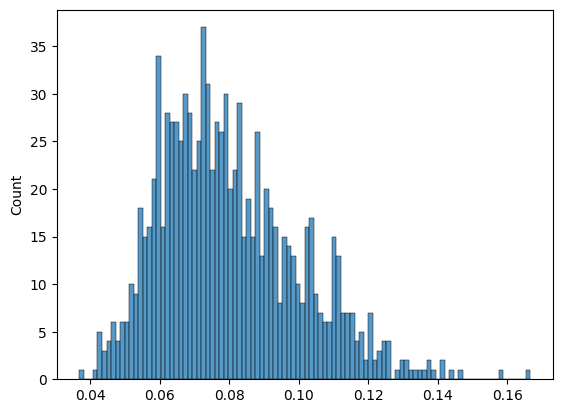

In [ ]:
sns.histplot(np.array(annual_returns), bins=100)

In [ ]:
df_random_portfolio_returns = pd.DataFrame({
    "portfolio": range(1000),
    "returns":annual_returns
})

df_random_portfolio_returns.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,portfolio,returns
count,1000.000000,1000.000000
mean,499.500000,0.080078
std,288.819436,0.019941
min,0.000000,0.036929
1%,9.990000,0.044738
5%,49.950000,0.053178
10%,99.900000,0.057390
25%,249.750000,0.064976
50%,499.500000,0.076924
75%,749.250000,0.092146


In [ ]:
df_random_portfolio_returns.to_csv("../data/random_portfolio_200_securities_returns.csv", index=False)